# Section mapper
---

### Overview
Notebook exemplifying how to acquire iCAT tiles given a segmented image of the sections

In [1]:
from pathlib import Path

from tqdm.notebook import tqdm
import numpy as np
from scipy import ndimage as ndi
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from matplotlib import patches

from skimage import (io, filters, transform, segmentation,
                     feature, measure, color)
from shapely import affinity
from shapely.geometry import polygon, box

import secdetect

In [2]:
# Enable autocomplete
%config Completer.use_jedi = False

# Set default matplotlib colormap
plt.set_cmap('magma')
plt.close()

### Load image

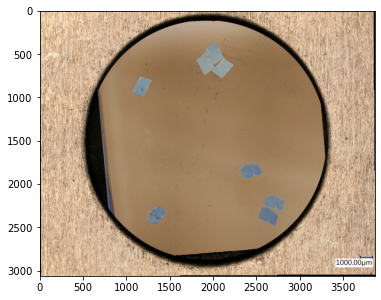

In [3]:
# Load section RGB image
fp = Path('D:rlane/Data/KEYENCE/_REPOSITORY/20210226_UMCG_RL016.tif')
image = io.imread(fp.as_posix())

# Plot section image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image);

## Detect sections
---

#### Remove background and create mask

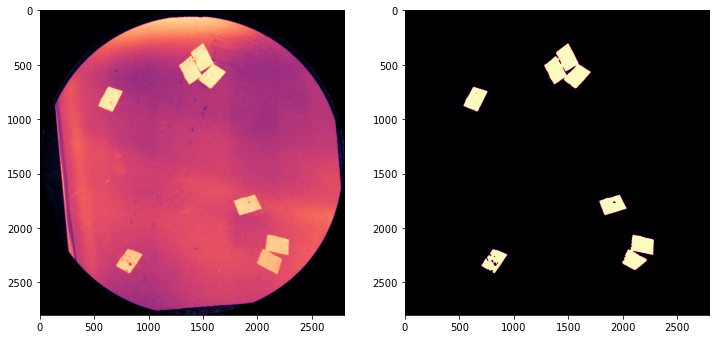

In [4]:
# Enhance contrast and threshold
imen = secdetect.enhance_contrast(image, channel=2)
imth = imen > filters.threshold_otsu(imen) / 5
# Find perimeter of glass circle and crop to circle
edges = feature.canny(imth)
cx, cy, r = secdetect.find_ring(edges)
cropped = secdetect.crop_to_ring(imen, cx, cy, r)

# Further processing
processed = filters.gaussian(cropped, sigma=2)
# Clip further and threshold
x, y = np.ogrid[:processed.shape[0], :processed.shape[1]]
x -= processed.shape[0]//2
y -= processed.shape[1]//2
mask = np.logical_and(
    processed > 0.62,
    np.where(x**2+y**2 > (r/1.15)**2, 0, 1).astype(bool)
)
# Erode and dilate to clean up specks
mask = ndi.morphology.binary_erosion(mask, iterations=5)
mask = ndi.morphology.binary_dilation(mask, iterations=5)

# Plot cropped image
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(processed)
axes[1].imshow(mask);

#### Some kind of segmentation

In [5]:
# Distance transform
distances = ndi.distance_transform_edt(mask)
seeds = feature.peak_local_max(distances, min_distance=100, footprint=np.ones((3, 3)))
seed_mask = np.zeros_like(distances, dtype=bool)
seed_mask[tuple(seeds.T)] = True
seeds_ = ndi.label(seed_mask)[0]
edges = feature.canny(processed, sigma=3)
segs_water = segmentation.watershed(edges, markers=seeds_, mask=mask)

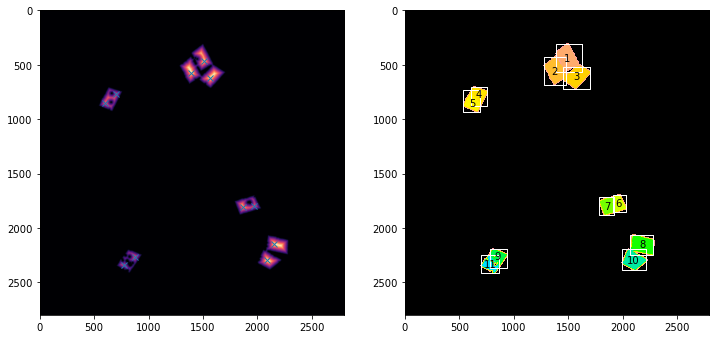

In [9]:
# Plot segmented image
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
axes[0].imshow(distances)
axes[0].plot(seeds[:, 1], seeds[:, 0], 'x')
axes[1].imshow(segs_water, cmap=secdetect.neon_cmap())

for i, region in enumerate(measure.regionprops(segs_water)):
    y0, x0, y1, x1 = region.bbox
    p = box(x0, y0, x1, y1)
    # Annotate sections
    axes[1].plot(*p.exterior.xy, color='white', lw=1)
    axes[1].text(x=region.centroid[1], y=region.centroid[0], s=i+1,
                 color='black', ha='center', va='center')

#### Merge oversegmented sections

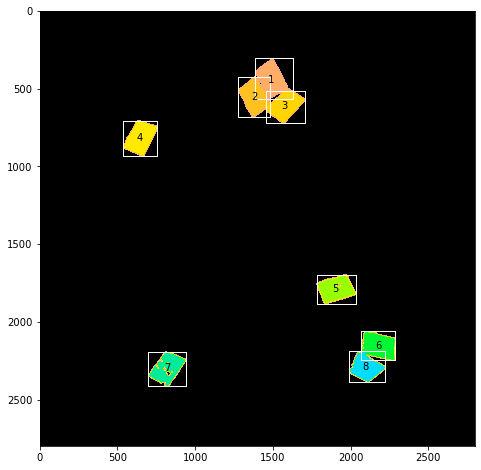

In [11]:
# Merge segments
segs_2_merge = [
    [4, 5],
    [6, 7],
    [9, 11],
]
section_image = segs_water  # make a copy to 
for segs in segs_2_merge:
    section_image = secdetect.merge_segments(section_image, segs, min(segs))

# Plot segmented image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(section_image, cmap=secdetect.neon_cmap())

for i, section in enumerate(measure.regionprops(section_image)):
    y0, x0, y1, x1 = section.bbox
    p = box(x0, y0, x1, y1)
    # Annotate sections
    ax.plot(*p.exterior.xy, color='white', lw=1)
    ax.text(x=section.centroid[1], y=section.centroid[0], s=i+1,
            color='black', ha='center', va='center')

## Section mapping
---

\begin{equation}
L = Nw - (N-1)ow
\end{equation}

\begin{equation}
N = \text{ceil}\left(\frac{L - ow}{w - ow}\right)
\end{equation}

In [12]:
from secdetect import find_minimum_bounding_rectangle, generate_tiles

FM HFW....... 217.1µm
EM HFW....... 108.5µm
FM overlap... 25.0%
EM overlap... 150.0%
Rotation..... 26.0°
Dimensions... 1100µm x 1598µm
Tile grid.... 7 x 10



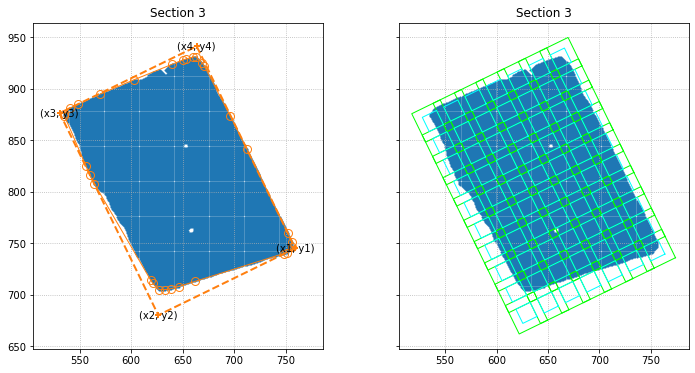

In [14]:
# Tiling parameters
px_FM = 0.106  # nm/px
scale = 0.1415  # px/um
w_FM = px_FM*2048 * scale  # px
o_FM = 0.25  # %
w_EM =  w_FM - 2*o_FM*w_FM
o_EM = (w_FM*(1-o_FM)) / w_EM
offset = w_FM/4

# Choose a random section from the segmented image
sections = measure.regionprops(section_image)
# k = np.random.RandomState(35).randint(0, len(sections))
k = np.random.randint(0, len(sections))
section = sections[k]

# Generate tiles
# --------------
tiles_FM, tiles_EM = generate_tiles(section=section,
                                    field_width=w_FM,
                                    overlap=o_FM,
                                    offset=offset,
                                    field_width_subtiles=w_EM)

# Compute convex hull
points = section.coords[:, ::-1]  # row, col --> x, y
hull = ConvexHull(points)
hull_points = points[hull.vertices]

# Minimum bounding rectangle
rect = find_minimum_bounding_rectangle(points)
x1, y1 = rect[0]
x2, y2 = rect[1]
x3, y3 = rect[2]
x4, y4 = rect[3]
rect = np.append(rect, [rect[0,:]], axis=0)  # complete the rectangle

# Calculate rotation
theta = np.arctan2(y2-y3, x2-x3)
theta += np.pi/2 if theta < -np.pi/4 else 0

# Calculate tiling stuff
# ----------------------
if theta >= 0:  # (x1, y1) is bottom right corner
    L = np.sqrt((x1-x2)**2 + (y1-y2)**2) + offset
    H = np.sqrt((x4-x1)**2 + (y4-y1)**2) + offset
else:  # (x1, y1) is top right corner
    L = np.sqrt((x4-x1)**2 + (y4-y1)**2) + offset
    H = np.sqrt((x1-x2)**2 + (y1-y2)**2) + offset
Nx = int(np.ceil((L-o_FM*w_FM)/(w_FM-o_FM*w_FM)))
Ny = int(np.ceil((H-o_FM*w_FM)/(w_FM-o_FM*w_FM)))

# Output
# ------
out = f"""\
FM HFW....... {px_FM*2048:.1f}µm
EM HFW....... {w_EM/scale:.1f}µm
FM overlap... {o_FM:.1%}
EM overlap... {o_EM:.1%}
Rotation..... {theta*180/np.pi:.1f}°
Dimensions... {L/scale:.0f}µm x {H/scale:.0f}µm
Tile grid.... {Nx} x {Ny}
"""; print(out)

# Plots
# -----
fig, axes = plt.subplots(ncols=2, figsize=(12, 6),
                         sharex=True, sharey=True)
# Plot convex hull
axes[0].plot(hull_points[:, 0], hull_points[:, 1], '-o',
             c='C1', mfc='none', lw=1, ms=8)
# Plot minimum bounding rectangle
axes[0].plot(rect[:, 0], rect[:, 1], '+--', mew=2, lw=2, c='C1')
# Plot vertices
for i, point in enumerate([(x1, y1), (x2, y2), (x3, y3), (x4, y4)]):
    axes[0].text(*point, f'(x{i+1}, y{i+1})', ha='center', va='center')
# Plot FM tiles
for tile in tiles_FM:
    axes[1].plot(*tile.exterior.xy, lw=1, color='#00ff00')
# Plot EM tiles
for tile in tiles_EM:
    axes[1].plot(*tile.exterior.xy, lw=1, color='#00ffff')
# Plot sections
for ax in axes:
    ax.plot(points[:, 0], points[:, 1], '.', ms=2, zorder=0)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    ax.set_title(f'Section {k}')
    ax.grid(ls=':')